In [76]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sb
from tqdm import tqdm
import pyfolio as pf

from scipy.stats import randint as sp_randint
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, roc_auc_score, roc_curve, auc
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV

current_dir = os.getcwd()

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (15,10)

pd.options.mode.chained_assignment = None  # default='warn'

In [78]:
file = open(os.path.join(current_dir, "data", "new_ratesmm.pickle"), 'rb')
target_dict = pickle.load(file)

signals = target_dict["signals"]["signals"]
bars = target_dict["bars"]

In [124]:
bkt_codes = ['TY1', 'FV1', 'TU1', 'CN1', 'IK1', 'RX1', 'DU1', 'OE1', 'OAT1', 'G 1', 'JB1', 'XM1', 'YM1']
bar_name = "Close"
seed = 199402
init_step = 90
predict_step = 4
param_distributions = {'C': np.linspace(0.001, 50, 200),
                       'l1_ratio': np.linspace(0.001, 0.999, 100)}
n_iter = 50
n_jobs = 3
n_splits = 5
ModelClass = LogisticRegression(fit_intercept=False,
                                penalty="elasticnet",
                                solver="saga")
time_split = TimeSeriesSplit(n_splits=n_splits)
roc_auc_scorer = make_scorer(roc_auc_score)

params = {}
aucs = {}
backtest = []
for bkt_code in bkt_codes:
    bar_df = bars[bkt_code][[bar_name]].resample("W-FRI").last()

    signals_df = signals[bkt_code].resample("W-FRI").last()

    y = bar_df[[bar_name]].pct_change()
    X = signals_df

    data = pd.concat([y, X], axis=1).dropna()

    y_train = data[[bar_name]]
    y_train.loc[y_train[bar_name] > 0, :] = 1
    y_train.loc[y_train[bar_name] < 0, :] = 0
    X_train = data.drop(bar_name, axis=1)

    tmp_params = []
    results = []
    count = 1
    for i in tqdm(range(init_step, (y_train.shape[0] - init_step), predict_step),
                  total=((y_train.shape[0] - init_step * 2) // predict_step + 1),
                  desc="Backtest " + bkt_code):
        y_loop = y_train.iloc[0:init_step + i]
        X_loop = X_train.iloc[0:init_step + i]

        y_loop_test = y_train[bar_name].iloc[(init_step + i):(init_step + i + predict_step)]
        X_loop_test = X_train.iloc[(init_step + i):(init_step + i + predict_step)]

        model_search = RandomizedSearchCV(estimator=ModelClass,
                                          param_distributions=param_distributions,
                                          n_iter=n_iter,
                                          cv=time_split,
                                          verbose=False,
                                          n_jobs=n_jobs,
                                          scoring=roc_auc_scorer,
                                          random_state=seed)
        model_search = model_search.fit(X_loop.to_numpy(), y_loop.to_numpy().ravel())
        test_pred = model_search.best_estimator_.predict_proba(X_loop_test)[:, 1]
        dict_ = {"date": y_loop_test.index,
                 "return_direction": y_loop_test.values,
                 "prediction": test_pred}
        result = pd.DataFrame(dict_)
        results.append(result)
        tmp_params.append(pd.DataFrame(model_search.best_estimator_.coef_, columns=X_loop.columns, index=[y_loop_test.index[-1]]))

    results_df = pd.concat(results, axis=0)
    results_df.loc[results_df["prediction"] > 0.55, "prediction_class"] = 1
    results_df.loc[results_df["prediction"] < 0.45, "prediction_class"] = -1
    results_df.loc[(results_df["prediction"] > 0.45) & (results_df["prediction"] < 0.55), "prediction_class"] = 0
    results_df.set_index("date", inplace=True)

    tmp_backtest_df = pd.concat([bar_df.pct_change(), results_df[["prediction_class"]]], axis=1).dropna()
    tmp_backtest_df[bkt_code] = tmp_backtest_df["Close"] * tmp_backtest_df["prediction_class"]

    backtest.append(tmp_backtest_df[[bkt_code]])
    
    # calculate scores
    lr_auc = roc_auc_score(results_df["return_direction"], results_df["prediction"])
    aucs[bkt_code] = lr_auc
    
    # save params
    tmp_params_df = pd.concat(tmp_params, axis=0).reset_index()
    params[bkt_code] = tmp_params_df

Backtest YM1: 100%|██████████| 125/125 [00:28<00:00,  4.38it/s]


In [125]:
backtest_df = pd.concat(backtest, axis=1)

Start date,2013-05-31
End date,2022-12-09
Total months,23
,Backtest
Annual return,22.4%
Cumulative returns,49.0%
Annual volatility,3.7%
Sharpe ratio,5.42
Calmar ratio,12.12
Stability,0.99
Max drawdown,-1.8%


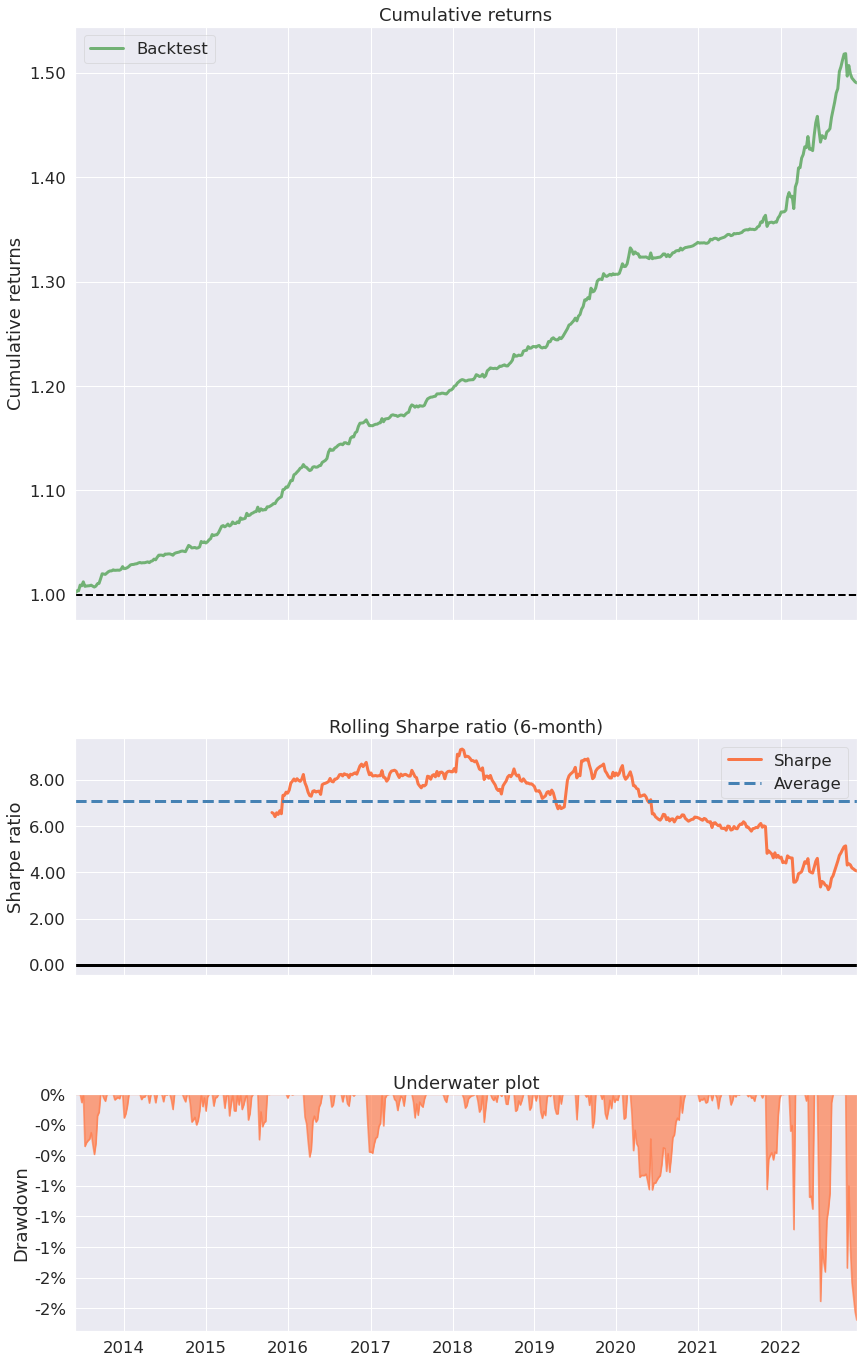

In [126]:
pf.create_simple_tear_sheet(backtest_df.mean(axis=1))

In [29]:
compare_df = pd.concat([backtest_df.mean(axis=1), target_dict["portfolio_returns"]["final_portfolio_returns"]], axis=1).dropna()

compare_df.head()

,0,RATESMM
date,,
2013-05-31,0.001933,-0.001153
2013-06-07,0.001863,-0.004089
2013-06-14,-0.000006,-0.002139
2013-06-21,0.004009,0.000248
2013-06-28,-0.000616,-0.000951


In [31]:
compare_df.corr()

,0,RATESMM
0,1.000000,0.035763
RATESMM,0.035763,1.000000


<AxesSubplot:xlabel='date'>

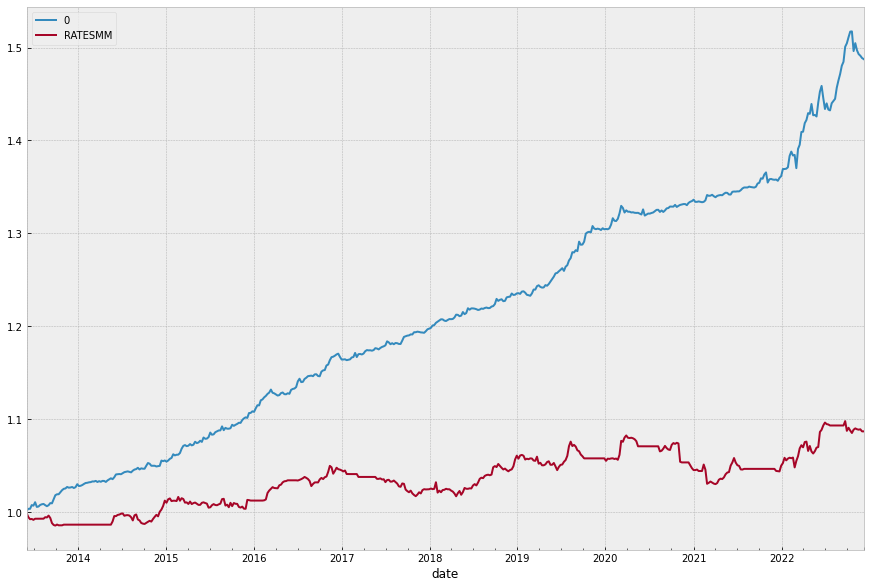

In [33]:
(1 + compare_df).cumprod().plot()

<AxesSubplot:xlabel='date'>

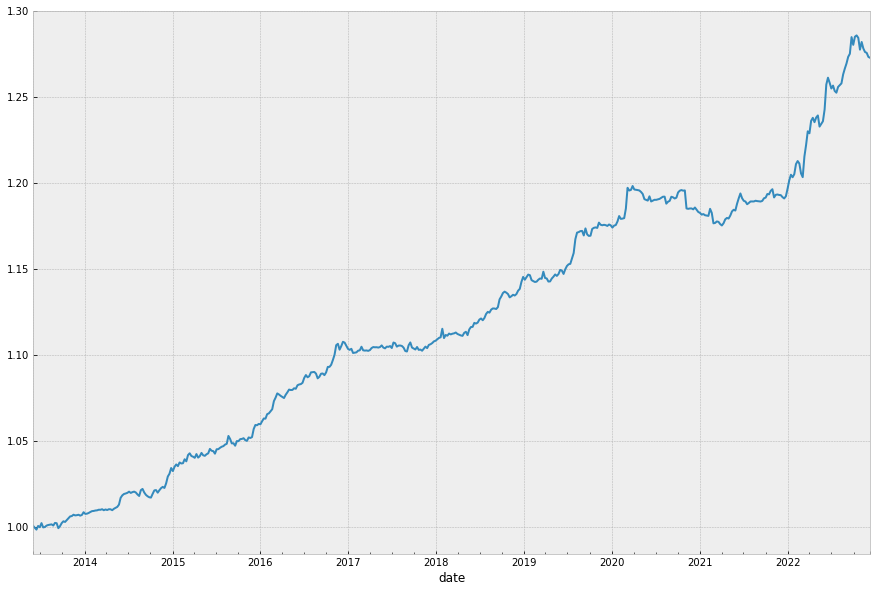

In [35]:
(1 + compare_df.mean(axis=1)).cumprod().plot()

In [16]:
aucs

{'TY1': 0.6237086776859504,
 'FV1': 0.6577945541360175,
 'TU1': 0.6509065685894955,
 'CN1': 0.6576865960743802,
 'IK1': 0.620985230086229,
 'RX1': 0.6624489795918367,
 'DU1': 0.6335310583844308,
 'OE1': 0.6528332406611739,
 'OAT1': 0.6853945480631276,
 'G 1': 0.6560604104814767,
 'JB1': 0.6383602711157457,
 'XM1': 0.6088109716651572,
 'YM1': 0.60435662806705}

In [199]:
results_df = pd.concat(results, axis=0)
ns_probs = [0 for _ in range(len(results_df))]

In [200]:
# calculate scores
ns_auc = roc_auc_score(results_df["return_direction"], ns_probs)
lr_auc = roc_auc_score(results_df["return_direction"], results_df["prediction"])
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.562


Text(0, 0.5, 'True Positive Rate')

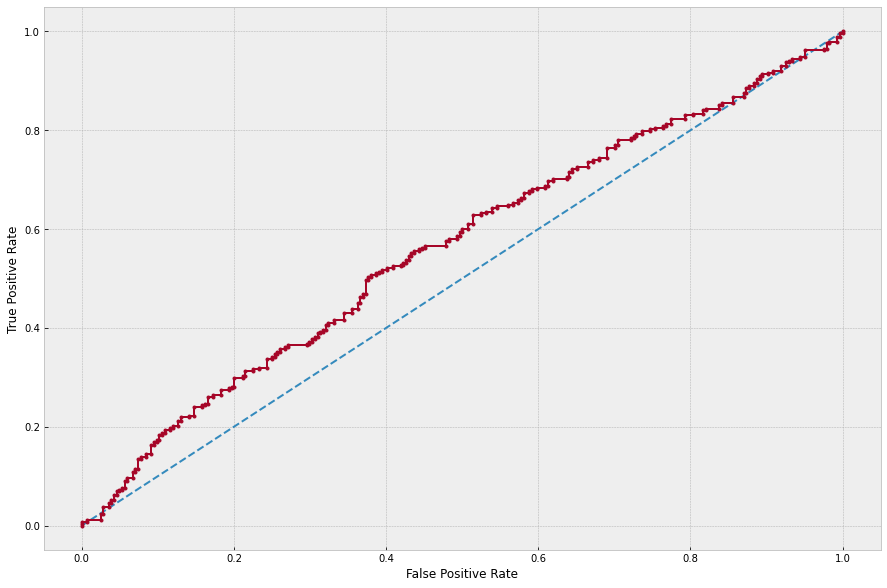

In [201]:
ns_fpr, ns_tpr, _ = roc_curve(results_df["return_direction"], ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(results_df["return_direction"], results_df["prediction"])
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

<AxesSubplot:xlabel='date'>

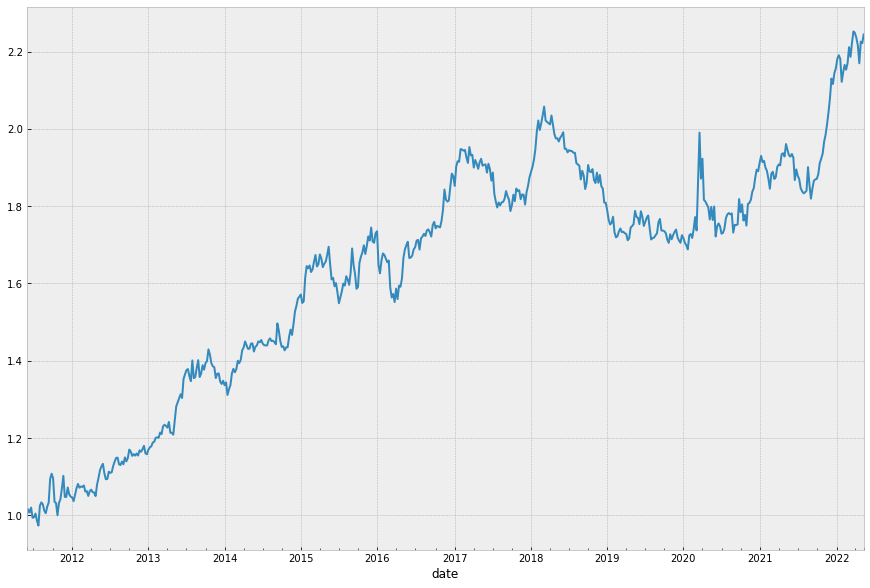

In [202]:
results_df.loc[results_df["prediction"] > 0.5, "prediction_class"] = 1
results_df.loc[results_df["prediction"] < 0.5, "prediction_class"] = -1
results_df.set_index("date", inplace=True)

backtest_df = pd.concat([bar_df.pct_change(), results_df[["prediction_class"]]], axis=1).dropna()
backtest_df["returns"] = backtest_df["Close"] * backtest_df["prediction_class"]
(1 + backtest_df["returns"]).cumprod().plot()